<a href="https://colab.research.google.com/github/AlamKhalid/ml-cifar-10/blob/master/Week_3_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 - Mini Project - Alam Khalid

Classification of data (CIFAR-10) using CNN


Starting with import statements

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose, RandomCrop, RandomHorizontalFlip
from torch.utils.data import random_split, DataLoader

Loading the dataset into respective variables and printing the length

In [ ]:
combined_transforms_train = Compose([RandomCrop(32, padding=4, padding_mode='reflect'),
                                     RandomHorizontalFlip(),
                                     ToTensor(),
                                     Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010),
                                     inplace=True)])
combined_transforms_test = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010),inplace=True)])

In [ ]:
dataset = CIFAR10(root='./data', train=True, download=True, transform=combined_transforms_train)
test_set = CIFAR10(root='./data', train=False, download=True, transform=combined_transforms_test)
len(dataset), len(test_set)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(50000, 10000)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
channels, width, height = dataset[0][0].shape
print(f"Channels: {channels}, Width: {width}, Height: {height}")

Channels: 3, Width: 32, Height: 32


Finding std and mean for normalizing data

In [ ]:
c_std = 0     # to store standard deviation
c_mean = 0    # to store mean

# loop through training examples
for data in dataset:
  img = data[0].view(3, -1)
  c_std += img.std(1)
  c_mean += img.mean(1)

In [ ]:
print(c_std / len(dataset), c_mean / len(dataset))

tensor([0.9907, 0.9904, 0.9887]) tensor([-0.0035, -0.0049, -0.0046])


Introducing seed so that gets same random each time

Splitting data into train and validation sets

In [ ]:
seed = 40
torch.manual_seed(seed);

val_size = 5000
test_size = len(test_set) - val_size

test_set, val_set = random_split(test_set, [test_size, val_size])
len(test_set), len(val_set)

(5000, 5000)

Converting the data into batches of size 64 as specified

In [ ]:
batch_size = 64

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_set, batch_size, num_workers=3, pin_memory=True)

Displaying first two images from the training dataset along with their correct label



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


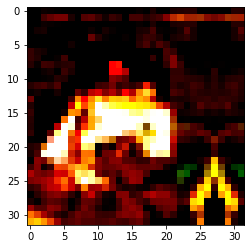

In [ ]:
plt.imshow(dataset[0][0].permute(1, 2, 0))
print(classes[dataset[0][1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


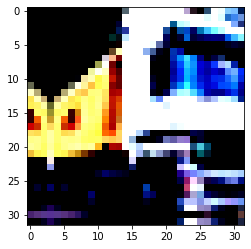

In [ ]:
plt.imshow(dataset[1][0].permute(1, 2, 0))
print(classes[dataset[1][1]])

Defining the model

In [ ]:
def get_model(dropout_rate):
  return nn.Sequential(
      # First Conv Layer
      nn.Conv2d(channels, 32, 3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 48, 3, padding=1),
      nn.BatchNorm2d(48),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),    # output [48, 16, 16]
      # Dropout 1
      nn.Dropout2d(dropout_rate),
      # Second Conv Layer
      nn.Conv2d(48, 64, 3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 128, 3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),    # output [128, 8, 8]
      # Dropout 2
      nn.Dropout2d(dropout_rate),
      # Third Conv Layer
      nn.Conv2d(128, 256, 3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),   # output [256, 4, 4]
      # Flatten Layer
      nn.Flatten(), 
      nn.Linear(256*4*4, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 10)
  )

Defining functions to move data to GPU

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

  
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)


class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
        
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl: 
      yield to_device(b, self.device)

    def __len__(self):
      """Number of batches"""
      return len(self.dl)

In [ ]:
device = get_default_device()
torch.cuda.empty_cache()
device

device(type='cuda')

In [ ]:
model = get_model(0.2)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(model, device);

Defining a function to calculate accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Defining one validation step to show accuracy and loss for a single batch

In [ ]:
def val_step(model, val_data):
  model.eval()
  losses = []
  accs = []
  torch.cuda.empty_cache()
  for batch in val_data:
    x, y = batch
    out = model(x)
    # calculating loss and accuracy
    loss = F.cross_entropy(out, y)
    acc = accuracy(out, y)
    # appending data
    losses.append(loss)
    accs.append(acc)
  epoch_loss = torch.stack(losses).mean().item()
  epoch_acc = torch.stack(accs).mean()
  print(f"Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_acc}")
  return {'val_loss': epoch_loss, 'val_acc': epoch_acc}

Defining a fit function

In [ ]:
def fit(model, train_data, epochs, opt, val_data):
  history_train = []
  history_val = []
  torch.cuda.empty_cache()
  for epoch in range(epochs):
    train_losses = []
    train_acc = []
    model.train()
    for batch in train_data:
      # making predictions
      images, labels = batch
      output = model(images)
      # calculating loss
      loss = F.cross_entropy(output, labels)
      # calculating accuracy 
      train_acc.append(accuracy(output, labels))
      # appending to losses list
      train_losses.append(loss)
      # computing gradients
      loss.backward()
      # performing parameter update
      opt.step()
      # set graients back to zero
      opt.zero_grad()
    calc_loss = torch.stack(train_losses).mean().item()
    calc_acc = torch.stack(train_acc).mean()
    print(f'For Epoch {epoch}, Loss: {calc_loss}, Accuracy: {calc_acc}')
    history_train.append({'epoch': epoch, 'loss': calc_loss, 'acc': calc_acc})
    history_val.append(val_step(model, val_data))
  return history_train, history_val

In [ ]:
train_history, train_val = fit(model, train_dl, 50, Adam(model.parameters(), weight_decay=1e-4), val_dl)

For Epoch 0, Loss: 1.5472474098205566, Accuracy: 0.4281090199947357
Validation Loss: 1.0956350564956665, Validation Accuracy: 0.5939477682113647
For Epoch 1, Loss: 1.1559033393859863, Accuracy: 0.5844789147377014
Validation Loss: 0.9177266359329224, Validation Accuracy: 0.6744462251663208
For Epoch 2, Loss: 0.9842332005500793, Accuracy: 0.6504955291748047
Validation Loss: 0.7501227855682373, Validation Accuracy: 0.7416930198669434
For Epoch 3, Loss: 0.8824077248573303, Accuracy: 0.6879995465278625
Validation Loss: 0.7188258767127991, Validation Accuracy: 0.7521756291389465
For Epoch 4, Loss: 0.8075135946273804, Accuracy: 0.7143142819404602
Validation Loss: 0.6170017123222351, Validation Accuracy: 0.7840189933776855
For Epoch 5, Loss: 0.7442042231559753, Accuracy: 0.739609956741333
Validation Loss: 0.6182409524917603, Validation Accuracy: 0.7826344966888428
For Epoch 6, Loss: 0.6986629366874695, Accuracy: 0.7557744383811951
Validation Loss: 0.6001200079917908, Validation Accuracy: 0.797

Defining an evaluate function

In [ ]:
def eval(model, data, type):
  model.eval()
  epoch = 0
  losses = []
  accuracies = []
  torch.cuda.empty_cache()
  for images, labels in data:
    # making predictions
    out = model(images)
    # calculating loss
    loss = F.cross_entropy(out, labels)
    # calculating accuracy
    acc = accuracy(out, labels)
    # appending data
    losses.append(loss)
    accuracies.append(acc)
    epoch += 1
  print(f"{type} Loss: {torch.stack(losses).mean().item()}, {type} Accuracy: {torch.stack(accuracies).mean()}")

In [ ]:
eval(model, val_dl, "Validation")

Validation Loss: 0.4319770038127899, Validation Accuracy: 0.8587890863418579


Function for plotting graphs

In [ ]:
def plot_accuracies(history, accuracy_name):
    accuracies = [x[accuracy_name] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Training Graph

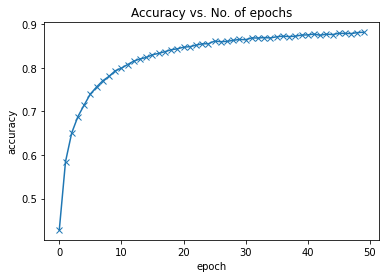

In [ ]:
plot_accuracies(train_history, 'acc')

Validation Graph

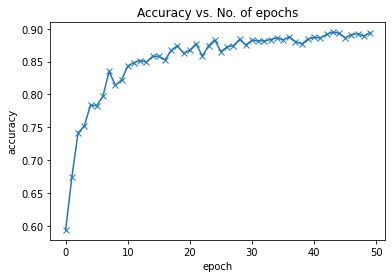

In [ ]:
plot_accuracies(train_val, 'val_acc')

Model on test set

In [ ]:
test_dl = DataLoader(test_set, 1, num_workers=3, pin_memory=True) # converting test set into batches of 1
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
eval(model, test_dl, "Test")

Test Loss: 0.3474072813987732, Test Accuracy: 0.8844000101089478


Printing and predicting images from test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: car, Predicted Label: car


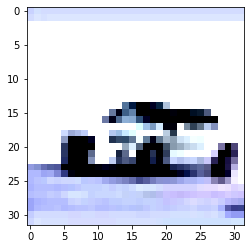

In [ ]:
# testing for first example only
for x, y in test_dl:
  out = model(x)
  probs = F.softmax(out, 1)
  _, pred = torch.max(probs, 1)
  plt.imshow(test_set[0][0].permute(1,2,0))
  print(f"Actual Label: {classes[y]}, Predicted Label: {classes[pred]}")
  break

Saving the weights for future use

In [ ]:
torch.save(model.state_dict(), 'cifar-10-model.pth')